<a href="https://colab.research.google.com/github/uqmshawn/uqmshawn-4-7-1-8-4-5-3-0-r/blob/main/47184530.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import zipfile
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import zipfile
from torchvision.utils import save_image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+------------+--------------+------------------------+
| Data Split | Total Images |      Image Shape       |
+------------+--------------+------------------------+
|  Training  |     9664     | torch.Size([128, 128]) |
|  Testing   |     544      | torch.Size([128, 128]) |
| Validation |     1120     | torch.Size([128, 128]) |
+------------+--------------+------------------------+


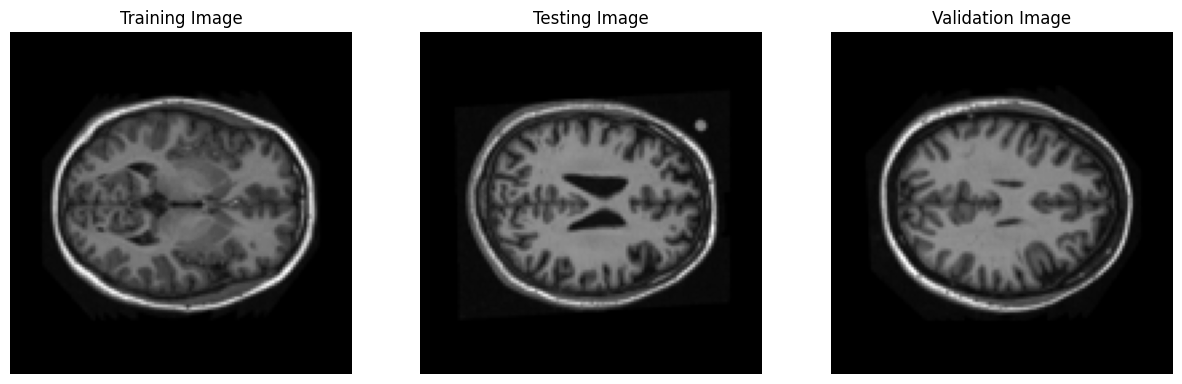

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [15]:
# Ensure that PyTorch uses the GPU (if available) or CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting Google Drive to access files. Note: This is specific to Google Colab.
drive.mount('/content/drive')

# Define the directory where the output will be saved
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/OUTPUT2"

# Create the directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Dataset class to handle brain slice images
class BrainSlicesDataset(Dataset):
    def __init__(self, image_slices):
        self.image_slices = image_slices

    def __len__(self):
        # Return the total number of image slices
        return len(self.image_slices)

    def __getitem__(self, idx):
        image = self.image_slices[idx]

        # Ensure the image has a channel dimension (grayscale images may not have one)
        if len(image.shape) == 2:  # If the image is of shape [Height, Width]
            image = torch.unsqueeze(image, 0)  # Convert it to [1, Height, Width]

        return image


# Function to load and extract image slices from a zip file
def get_image_slices():
    # Path to the zipped dataset
    zip_path = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/testgans/GAN_Dataset.zip"
    extraction_path = "/content/GAN_Dataset"
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    # Define the directories for training, testing, and validation datasets
    parent_dir = "/content/GAN_Dataset"
    train_path = os.path.join(parent_dir, "keras_png_slices_train")
    test_path = os.path.join(parent_dir, "keras_png_slices_test")
    val_path = os.path.join(parent_dir, "keras_png_slices_validate")

    # Helper function to load images from a directory
    def load_images_from_folder(folder_path):
        images = []
        for filename in os.listdir(folder_path):
            # Open the image, convert to grayscale, and resize to 128x128 pixels
            img = Image.open(os.path.join(folder_path, filename)).convert('L').resize((128, 128))
            if img is not None:
                # Convert the image to a tensor and append to the list
                images.append(torch.tensor(np.array(img, dtype=np.float32)))
        return torch.stack(images)  # Convert list of tensors to a single tensor

    # Load images from each directory
    train_images = load_images_from_folder(train_path)
    test_images = load_images_from_folder(test_path)
    validate_images = load_images_from_folder(val_path)

    return train_images, test_images, validate_images


# Function to retrieve the image slices and provide a summary with a table and example images
def get_image_slices_with_table():
    train_images, test_images, validate_images = get_image_slices()

    # Display a summary table using PrettyTable
    table = PrettyTable()
    table.field_names = ["Data Split", "Total Images", "Image Shape"]
    table.add_row(["Training", len(train_images), train_images[0].shape])
    table.add_row(["Testing", len(test_images), test_images[0].shape])
    table.add_row(["Validation", len(validate_images), validate_images[0].shape])

    print(table)

    # Plot an example image from each dataset split
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(train_images[0], cmap='gray')
    axs[0].set_title("Training Image")
    axs[0].axis('off')

    axs[1].imshow(test_images[0], cmap='gray')
    axs[1].set_title("Testing Image")
    axs[1].axis('off')

    axs[2].imshow(validate_images[0], cmap='gray')
    axs[2].set_title("Validation Image")
    axs[2].axis('off')

    plt.show()

    return train_images, test_images, validate_images

# Call the function to display the dataset summary and example images
get_image_slices_with_table()

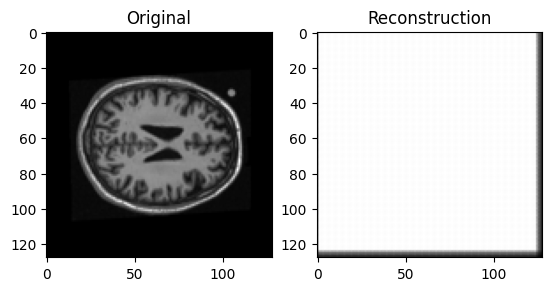

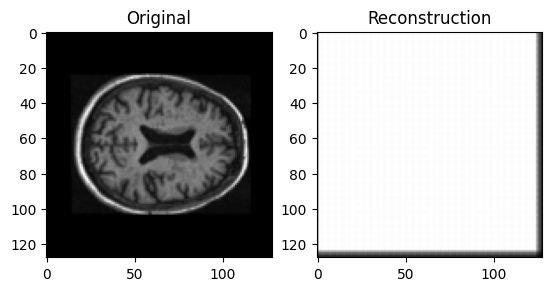

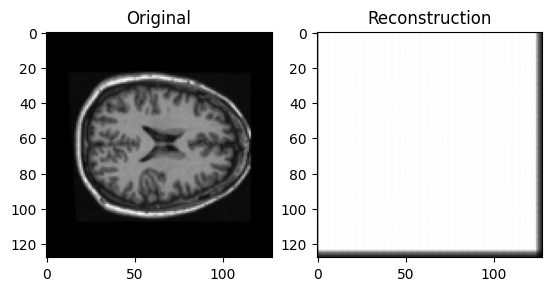

Epoch [1/20], Loss: 1.1359


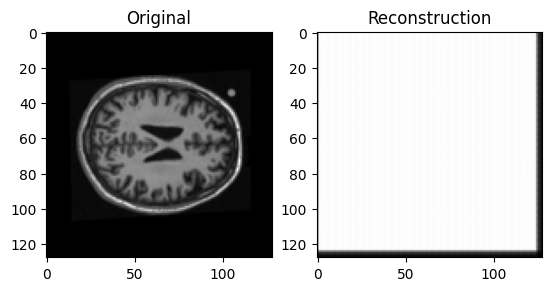

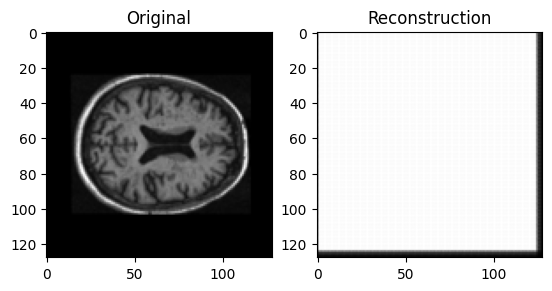

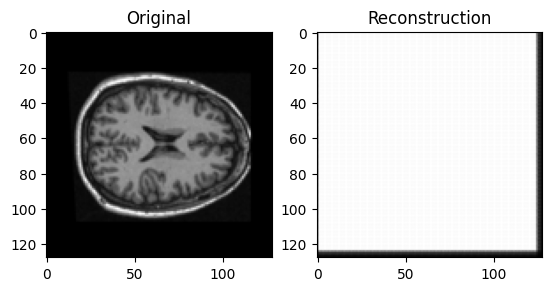

Epoch [2/20], Loss: 0.9987


KeyboardInterrupt: ignored

In [16]:
# 2. Model Definitions

# The Vector Quantizer layer performs the quantization of the encoder's outputs.
# This is where the continuous representations from the encoder are mapped to a discrete set of embeddings.
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()

        # Embedding dimension: size of each embedding vector
        self.embedding_dim = embedding_dim

        # Number of embeddings: total number of discrete embeddings in our codebook
        self.num_embeddings = num_embeddings

        # Beta is a hyperparameter that weights the commitment loss
        self.beta = beta

        # Initialize the embeddings (codebook) with random values. It's a learnable parameter.
        self.embeddings = nn.Parameter(torch.randn(embedding_dim, num_embeddings))

    def forward(self, x):
        # Reshape the tensor to compute distances
        z_e_x = x.permute(0, 2, 3, 1).contiguous()
        z_e_x_ = z_e_x.view(-1, self.embedding_dim)

        # Compute pairwise distances between input and the codebook
        distances = (torch.sum(z_e_x_**2, dim=1, keepdim=True)
                    + torch.sum(self.embeddings**2, dim=0)
                    - 2 * torch.matmul(z_e_x_, self.embeddings))

        # Find the closest embedding index for each item in the batch
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Create a one-hot encoding of the indices
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(x.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Reshape the encoding indices to have the same spatial dimensions as input
        encoding_indices = encoding_indices.view(*z_e_x.shape[:-1])

        # Use the encodings to get the quantized values from the codebook
        quantized = torch.matmul(encodings, self.embeddings.t()).view(*z_e_x.shape)

        # Compute the commitment loss and the quantization loss
        e_latent_loss = F.mse_loss(quantized.detach(), z_e_x)
        q_latent_loss = F.mse_loss(quantized, z_e_x.detach())
        loss = q_latent_loss + self.beta * e_latent_loss

        # Straight-through estimator: gradients bypass the non-differentiable operation
        quantized = z_e_x + (quantized - z_e_x).detach()

        # Compute perplexity to check how many codebook entries are being used
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

# The Encoder module maps the input images to a continuous representation that will be quantized by the Vector Quantizer.
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, embedding_dim):
        super(Encoder, self).__init__()

        # Define the encoder neural network
        # The encoder consists of three convolutional layers with ReLU activations.
        self.encoder = nn.Sequential(
            # First convolutional layer: it takes the input image and produces 'hidden_channels' feature maps.
            nn.Conv2d(input_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Second convolutional layer: reduces the spatial dimensions by half and reduces the number of feature maps.
            nn.Conv2d(hidden_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Third convolutional layer: prepares the tensor for quantization by setting the number of channels to 'embedding_dim'.
            nn.Conv2d(hidden_channels // 2, embedding_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Forward propagation of input through the encoder
        return self.encoder(x)

# The Decoder module maps the quantized representation back to the space of the original image.
class Decoder(nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(Decoder, self).__init__()

        # Define the decoder neural network
        # The decoder consists of three transposed convolutional layers (sometimes called "deconvolutional layers") with ReLU activations.
        self.decoder = nn.Sequential(
            # First transposed convolutional layer: it takes the quantized representation and increases the spatial dimensions.
            nn.ConvTranspose2d(input_channels, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            # Second transposed convolutional layer: further increases the spatial dimensions.
            nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            # Third transposed convolutional layer: produces the final output with the same shape as the original image.
            nn.ConvTranspose2d(hidden_channels // 2, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Forward propagation of the quantized representation through the decoder
        return self.decoder(x)

# The VQ-VAE module combines the encoder, vector quantizer, and decoder components.
class VQVAE(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()

        # Initialize the encoder module
        self.encoder = Encoder(input_channels, hidden_channels, embedding_dim)

        # Initialize the vector quantization module
        self.quantize = VectorQuantizer(num_embeddings, embedding_dim)

        # Initialize the decoder module
        self.decoder = Decoder(embedding_dim, hidden_channels)

    def forward(self, x):
        # Encode the input image to a continuous representation
        z = self.encoder(x)

        # Quantize the continuous representation
        loss, quantized, perplexity, _ = self.quantize(z)

        # Decode the quantized representation to produce the reconstruction
        x_recon = self.decoder(quantized)

        return loss, x_recon, perplexity

# The VQVAETrainer module facilitates the training of the VQ-VAE model.
class VQVAETrainer(nn.Module):
    def __init__(self, train_variance, input_channels, hidden_channels, num_embeddings, embedding_dim):
        super(VQVAETrainer, self).__init__()

        # Store the variance of the training data (used for normalization)
        self.train_variance = train_variance

        # Initialize the VQ-VAE model
        self.vqvae = VQVAE(input_channels, hidden_channels, num_embeddings, embedding_dim)

    def forward(self, x):
        # Forward propagation of the input through the VQ-VAE
        vq_loss, x_recon, perplexity = self.vqvae(x)

        # Compute the reconstruction loss normalized by the training data variance
        recon_loss_value = F.mse_loss(x_recon, x) / self.train_variance

        # Overall loss is the sum of reconstruction loss and vector quantization loss
        loss = recon_loss_value + vq_loss

        return x_recon, perplexity, loss

# The PixelConvLayer is a custom convolutional layer used in the PixelCNN.
# It ensures that each pixel only depends on other pixels above it or to its left.
class PixelConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()

        # Define the mask type (either 'A' or 'B')
        self.mask_type = mask_type

        # Compute padding to ensure the convolution is 'same' (output size == input size)
        self.padding = (kernel_size - 1) // 2

        # Define the convolutional layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs, padding=self.padding)

        # Initialize the mask to be applied on the convolutional weights
        self.mask = self.conv.weight.data.clone()

        # Create the mask
        self.create_mask()

    def forward(self, x):
        # Apply the mask to the convolutional weights
        self.conv.weight.data *= self.mask.to(self.conv.weight.device)

        # Apply the convolution
        return self.conv(x)

    def create_mask(self):
        _, _, H, W = self.conv.weight.size()

        # Set the mask to ones initially
        self.mask.fill_(1)

        # For mask type 'A', the center pixel and all pixels to the right are set to zero
        # For mask type 'B', all pixels to the right of the center pixel are set to zero
        self.mask[:, :, H // 2, W // 2 + (self.mask_type == 'A'):] = 0

        # All pixels below the center pixel are set to zero
        self.mask[:, :, H // 2 + 1:] = 0

# The PixelCNN model comprises several PixelConvLayers.
class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, embedding_dim):
        super(PixelCNN, self).__init__()

        # Define the input shape of the image
        self.input_shape = input_shape

        # Define the embedding dimension
        self.embedding_dim = embedding_dim

        # Define the number of embeddings (or the number of different pixel values)
        self.num_embeddings = num_embeddings

        # Define the architecture of the PixelCNN
        self.layers = nn.ModuleList()

        # The first layer has a mask type 'A'
        self.layers.append(PixelConvLayer(input_shape[0], embedding_dim, 7, mask_type='A'))

        # Subsequent layers have a mask type 'B'
        for _ in range(5):
            self.layers.append(PixelConvLayer(embedding_dim, embedding_dim, 7, mask_type='B'))

        # The final layer reduces the number of channels to the number of embeddings
        self.layers.append(nn.Conv2d(embedding_dim, num_embeddings, 1))

    def forward(self, x):
        # Forward propagation through the PixelCNN
        for layer in self.layers:
            x = F.relu(layer(x))
        return x


# 3. Training Functions

# This function trains the VQ-VAE model.
def train_vqvae(vqvae, train_loader, num_epochs, learning_rate, test_samples, recon_losses, vq_losses, perplexities):
    # Set up the optimizer for training (Adam in this case).
    optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)

    # Loop through each epoch.
    for epoch in range(num_epochs):
        # Loop through each batch of images from the DataLoader.
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)  # Transfer images to the GPU if available.

            # Zero the gradients.
            optimizer.zero_grad()

            # Forward pass through the VQ-VAE.
            x_recon, perplexity, loss = vqvae(images)

            # Compute reconstruction and VQ losses.
            recon_loss_value = F.mse_loss(x_recon, images) / vqvae.train_variance
            vq_loss_value = loss - recon_loss_value

            # Record the losses and perplexity for plotting later.
            recon_losses.append(recon_loss_value.item())
            vq_losses.append(vq_loss_value.item())
            perplexities.append(perplexity.item())

            # Backward pass.
            loss.backward()

            # Update the weights.
            optimizer.step()

        # At the end of each epoch, visualize some reconstructed images.
        with torch.no_grad():
            reconstructions, _, _ = vqvae(test_samples)
            visualize_reconstructions(test_samples.cpu(), reconstructions.cpu())

            # Save the generated images
            save_path = os.path.join(OUTPUT_DIR, f"{epoch}.png")
            save_image(reconstructions, save_path)

        # Print the loss for the current epoch.
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # At the end of training, plot the recorded losses and perplexity.
    plt.figure(figsize=(10,5))
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(vq_losses, label='VQ Loss')
    plt.legend()
    plt.title('Losses over Training')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss Value')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(perplexities)
    plt.title('Perplexity over Training')
    plt.xlabel('Training Iterations')
    plt.ylabel('Perplexity')
    plt.show()

    # Visualize the histogram of encoding indices.
    with torch.no_grad():
        _, _, _, encoding_indices = vqvae.vqvae.quantize(vqvae.vqvae.encoder(test_samples))
        encoding_indices = encoding_indices.flatten().cpu().numpy()

    plt.figure(figsize=(10,5))
    plt.hist(encoding_indices, bins=np.arange(vqvae.vqvae.quantize.num_embeddings+1)-0.5, rwidth=0.8)
    plt.title('Histogram of Encoding Indices')
    plt.xlabel('Encoding Index')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(vqvae.vqvae.quantize.num_embeddings))
    plt.show()

        # Print the recorded losses and perplexities
    print("Reconstruction Losses:", recon_losses)
    print("VQ Losses:", vq_losses)
    print("Perplexities:", perplexities)

# This function trains the PixelCNN model.
def train_pixelcnn(pixelcnn, train_loader, num_epochs, learning_rate):
    optimizer = optim.Adam(pixelcnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Loop through each epoch.
    for epoch in range(num_epochs):
        # Loop through each batch of images from the DataLoader.
        for images in train_loader:
            images = images.to(device)  # Transfer images to the GPU if available.

            # Zero the gradients.
            optimizer.zero_grad()

            # Forward pass through the PixelCNN.
            logits = pixelcnn(images)

            # Compute the loss.
            loss = criterion(logits, images.squeeze(1).long())

            # Backward pass.
            loss.backward()

            # Update the weights.
            optimizer.step()

        # Print the loss for the current epoch.
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 4. Visualization

# This function visualizes original vs reconstructed images.
def visualize_reconstructions(originals, reconstructions, num_samples=3):
    # Loop through the number of samples specified.
    for i in range(num_samples):
        # Create a subplot for the original and reconstructed images.
        fig, axs = plt.subplots(1, 2)

        # Display the original image.
        axs[0].imshow(originals[i, 0].detach().numpy(), cmap='gray')
        axs[0].set_title("Original")

        # Display the reconstructed image.
        axs[1].imshow(reconstructions[i, 0].detach().numpy(), cmap='gray')
        axs[1].set_title("Reconstruction")

        # Remove axis ticks and labels.
        plt.show()

# This function visualizes generated samples.
def visualize_samples(samples, num_samples=3):
    # Loop through the number of samples specified.
    for i in range(num_samples):
        # Display the generated image.
        plt.imshow(samples[i, 0].detach().cpu().numpy(), cmap='gray')
        plt.title("Generated Sample")
        plt.show()

# This function visualizes images generated using PixelCNN.
def visualize_pixelcnn_generation_batch(pixelcnn, batch_size, img_size=(1, 128, 128)):
    # Create a batch of empty images.
    samples = torch.zeros(batch_size, *img_size).to(device)

    # Generate images pixel by pixel.
    for i in range(img_size[1]):
        for j in range(img_size[2]):
            out = pixelcnn(samples)
            probs = F.softmax(out[:, :, i, j], dim=1)
            for b in range(batch_size):
                samples[b, :, i, j] = torch.multinomial(probs[b], 1).float() / 255.0

    # Display the generated images.
    for b in range(batch_size):
        plt.imshow(samples[b, 0].cpu().detach().numpy(), cmap='gray')
        plt.title(f"PixelCNN Generated Sample {b+1}")
        plt.show()

# This function compares an original image with one generated by PixelCNN.
def compare_original_and_generated(original, pixelcnn, img_size=(1, 128, 128)):
    # Generate an image using PixelCNN.
    generated = torch.zeros(img_size).to(device)
    for i in range(img_size[1]):
        for j in range(img_size[2]):
            out = pixelcnn(generated)
            probs = F.softmax(out[:, :, i, j], dim=1)
            generated[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.0

    # Create a subplot for the original and PixelCNN generated images.
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image.
    axs[0].imshow(original[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[0].set_title("Original")

    # Display the PixelCNN generated image.
    axs[1].imshow(generated[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[1].set_title("PixelCNN Generated")

    # Remove axis ticks and labels.
    plt.show()


# 5. Main Function

def main():

    # Lists to store loss values and perplexities for visualization
    recon_losses = []
    vq_losses = []
    perplexities = []

    # Load the brain slices images
    train_images, test_images, _ = get_image_slices()
    # Create a dataset and data loader using the train images
    dataset = BrainSlicesDataset(train_images)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Create a batch of test images for visualization purposes
    test_samples_for_viz = torch.stack([test_images[i].unsqueeze(0) for i in range(3)]).to(device)

    # Initialize the VQ-VAE model and move it to the appropriate device (GPU or CPU)
    vqvae_model = VQVAE(input_channels=1, hidden_channels=128, num_embeddings=512, embedding_dim=32).to(device)
    optimizer = torch.optim.Adam(vqvae_model.parameters(), lr=0.001)

    # Initialize the VQVAE trainer model and move it to the appropriate device
    vqvae = VQVAETrainer(train_images.var(), 1, 128, 512, 32).to(device)
    # Train the VQVAE model
    train_vqvae(vqvae, train_loader, num_epochs=20, learning_rate=0.001, test_samples=test_samples_for_viz, recon_losses=recon_losses, vq_losses=vq_losses, perplexities=perplexities)

    # Initialize the PixelCNN model and move it to the appropriate device
    pixelcnn = PixelCNN((1, 128, 128), 256, 10).to(device)
    # Train the PixelCNN model
    train_pixelcnn(pixelcnn, train_loader, num_epochs=40, learning_rate=0.001)

    # Generate images using the trained PixelCNN
    with torch.no_grad():
        pixelcnn_generated_samples = torch.zeros(3, 1, 128, 128).to(device)  # batch of 3 empty images
        for i in range(128):
            for j in range(128):
                out = pixelcnn(pixelcnn_generated_samples)
                probs = F.softmax(out[:, :, i, j], dim=1)
                for b in range(3):  # For each image in the batch
                    pixelcnn_generated_samples[b, :, i, j] = torch.multinomial(probs[b], 1).float() / 255.0
        # Visualize the images generated by the PixelCNN
        visualize_samples(pixelcnn_generated_samples)

    # Visualization of reconstructions using the VQ-VAE model
    with torch.no_grad():
        # Get some test images for reconstruction visualization
        test_samples = torch.stack([test_images[i] for i in range(3)]).to(device)
        reconstructions, _, _ = vqvae(test_samples)
        # Visualize the reconstructions
        visualize_reconstructions(test_samples, reconstructions)

        # Visualize multiple images generated by the PixelCNN
        visualize_pixelcnn_generation_batch(pixelcnn, batch_size=5)

        # Compare an original image with an image generated by the PixelCNN
        for i in range(3):  # For 3 examples
            compare_original_and_generated(test_samples[i], pixelcnn)
    return recon_losses, vq_losses, perplexities

    # Print the recorded losses and perplexities
    print("Reconstruction Losses:", recon_losses)
    print("VQ Losses:", vq_losses)
    print("Perplexities:", perplexities)

if __name__ == "__main__":
     main()

